<a href="https://colab.research.google.com/github/yigitv4rli/CENG501-Spring2022/blob/main/Project_Kose_Varli/experiments/cifar10_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries here
import torch 
import math
import pandas as pd
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import json
from torch.utils.data import DataLoader
from google.colab import drive

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Utility Functions

This section includes utility functions overall model
1. Learning Schedulers
2. Data Loaders
3. Train and Test Accuracy
4. Result Saving
5. Plotting

In [ ]:
# scheduler functions
def constant_learning_rate_scheduler(lr):
    def scheduler(_):
        return lr
    return scheduler

def cosine_learning_rate_scheduler(lr, epoch_count):
    def scheduler(current_epoch):
        return lr * (1 + math.cos(current_epoch * math.pi / epoch_count))
    return scheduler

def diminishing_learning_rate_scheduler(lr, alpha):
    def scheduler(current_epoch):
        return lr / ((current_epoch + alpha) ** (1/3))
    return scheduler

def exponential_learning_rate_scheduler(lr, alpha):
    def scheduler(current_epoch):
        return lr * (alpha ** current_epoch)
    return scheduler


# function that saves history a json
def save_history_json(file_name, history):
  with open(file_name, "w") as out:
    json.dump(history, out)

In [ ]:
# data loaders for cifar10 and fashionmnist
def cifar10_loader(batch_size, ssmg):
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    
    # a check if the loader is called for Single Shuffling Momentum Gradient (SSMG)
    # we do shuffling once at the beginning then we create the train loader
    if ssmg:
        shuffled_set = torch.utils.data.Subset(train_set, torch.randperm(len(train_set)))
        train_loader = torch.utils.data.DataLoader(shuffled_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2) 

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    # classes = ('plane', 'car', 'bird', 'cat',
    #        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')     

    return train_loader, test_loader

def fashionmnist_loader(batch_size, ssmg):
    transform = transforms.Compose([transforms.ToTensor()])
    
    train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                                download=True, transform=transform,) 
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # a check if the loader is called for Single Shuffling Momentum Gradient (SSMG)
    # we do shuffling once at the beginning then we create the train loader
    if ssmg:
        shuffled_set = torch.utils.data.Subset(train_set, torch.randperm(len(train_set)))
        train_loader = torch.utils.data.DataLoader(shuffled_set, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                download=True, transform=transform,) 
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
def train_and_test_accuracy(model, train_loader, test_loader):
    total, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total

    total, correct = 0, 0
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total

    return train_accuracy, test_accuracy

In [ ]:
def plot_loss(history):
    plt.legend(fontsize = 18)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.xlabel('Number of effective passes', fontsize = 25)
    plt.ylabel('Train Loss', fontsize = 25)
    plt.yscale('log')
    loss_history = history['loss_history']
    x = [i for i in range(10,210,10)]
    y = [np.sum(loss_history[k:k+10])/10 for k in range(0,200,10)]
    plt.plot(x, y, '-ok', color='blue')

def plot_norm_square_grad(history):
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.xlabel('Number of effective passes', fontsize = 18)
    plt.ylabel('Grad loss', fontsize = 18)
    plt.yscale('log')
    grad_history = history['grad_history']
    x = [i for i in range(10,210, 10)]
    y = [np.sum(grad_history[y:y+10])/10 for y in range(0,200,10)]
    plt.plot(x, y, '-ok', color='red')


# Trainers

In [ ]:
# This trainer trains the net using the SMG algorithm proposed in the paper.
# We named the variables identical with the paper's algorithm notation. Different from paper
# the types we used are PyTorch tensors.
def SMG_train(model, criterion, epochs, train_loader, test_loader, scheduler, beta, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """
  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  
  #Note that velocity depends on gradient. So, per each different weight gradient we will have a different velocity, thus different momentum.
  #Therefore, we store velocity and momentum per weight seperately.
  m = dict()
  v = dict()
  # Initialize momentum and velocity dictionaries for weights with zeros.
  for n, w in model.named_parameters():
    m[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)
    v[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)



  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
    # At the beginning of each epoch
    # Set m = v
    for n, w in model.named_parameters():
      m[n] = v[n]
    
    # Set v = 0
    for n, w in model.named_parameters():
      v[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)


    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      normalizer = labels.size(0) / len(train_loader.dataset)

      # zero the gradients as PyTorch accumulates them
      model.zero_grad()

      # Obtain the scores
      outputs = model(inputs)
      print(outputs.shape)
      print(labels.shape)
      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      total_loss += loss.item() * normalizer;

      # Backpropagate
      loss.backward()

      # Paper proposes an alternative scheme to update the weights using momentum with batch shuffling. 
      for n, w in model.named_parameters():
        with torch.no_grad():
          #Pytorch computes a batch gradient which is 1/batch_size * grad. In update scheme we use 1/n so we set a grad_scale to compansate that.
          g_scale = labels.size(0) / len(train_loader.dataset) #batch_size / dataset_size
          #Update v
          v[n] += g_scale * w.grad.data
          delta = beta * m[n] + (1-beta) * w.grad.data #weight_update
          w.data += -lr * delta



      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      
    
    
    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)
    
    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')
    
  return history

In [ ]:
# This trainer trains the net using the SSMG algorithm proposed in the paper.
# We named the variables identical with the paper's algorithm notation. Different from paper
# the types we used are PyTorch tensors. Also, SSMG is single shuffle variant of SMG so batches wont 
# be reshuffled every epoch.
def SSMG_train(model, criterion, epochs, train_loader, test_loader, scheduler, beta, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """
  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  


  m = dict()
  # Initialize momentum dictionaries for weights with zeros.
  for n, w in model.named_parameters():
    m[n] = torch.zeros_like(w.data, memory_format = torch.preserve_format)



  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
  
    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      #There is no momentum update here. We want to preserve the momentum value of the
      #previous epoch.

      normalizer = labels.size(0) / len(train_loader.dataset)

      # zero the gradients as PyTorch accumulates them
      model.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      total_loss += loss.item() * normalizer;

      # Backpropagate
      loss.backward()

      # Paper proposes an alternative scheme to update the weights using momentum with single batch shuffling. 
      for n, w in model.named_parameters():
        with torch.no_grad():
          g_scale = labels.size(0) / len(train_loader.dataset) #batch_size / dataset_size
          #Update momentum in every iteration (Most important difference from SMG)
          m[n] = beta * m[n] + (1-beta) * w.grad.data
          w.data += -lr * m[n] #weight_update using the momentum directly



      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      
    
    
    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)
    
    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')
    
  return history

In [ ]:
# This is a general trainer that uses PyTorch's built-in optimizers.
# This function will be used compare other optimizers with SMG
def train(model, criterion, optimizer, epochs, train_loader, test_loader, scheduler, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the dictionary of history that includes loss, grads, test and train accuracies.
  """
  history = dict()
  history['loss_history'], history['grad_history'] = list(), list()
  history['test_acc_history'], history['train_acc_history'] = list(), list()
  #Note that we have activated shuffling. When iterator advances to the end
  #of the batches reshuffles. This is effectively shuffling the batch
  #before every batch.
  for epoch in range(epochs):
    total_loss = 0
    total_grad_norm = 0
    lr = scheduler(epoch+1)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 

    for i, data in enumerate(train_loader, 0):    
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      normalizer = labels.size(0) / len(train_loader.dataset)


      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs.to(device), labels)
      total_loss += loss.item() * normalizer;

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      #Measure grad_square
      for p in model.parameters():
          param_norm = p.grad.detach().data.norm(2)
          total_grad_norm += param_norm.item() ** 2 * normalizer
      

    history['grad_history'].append(total_grad_norm)
    history['loss_history'].append(total_loss)

    train_acc, test_acc = train_and_test_accuracy(model, train_loader, test_loader)
    history['train_acc_history'].append(train_acc)
    history['test_acc_history'].append(test_acc)
    loss_history = history['loss_history']
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. loss of last epoch {total_loss}')
    if verbose: print(f'Epoch {epoch+1} / {epochs}: avg. grad_norm of last epoch {total_grad_norm}')
    if verbose: print(f'Current train acc: {train_acc}%, test acc: {test_acc}%')  

  return history

# Networks

In [ ]:
import torch.nn.functional as F
#-------------------------(LeNet5 for Cifar10)-------------------------------
class LeNet5 (nn.Module):
    def __init__ (self):
        super().__init__()

        # This network is for images of size 32x32, with 3 color channels  (Cifar10 dataset)
        self.conv1 = nn.Conv2d (3, 6, 5)
        self.pool = nn.MaxPool2d (2,2)
        self.conv2 = nn.Conv2d (6, 16, 5)
        self.fc1 = nn.Linear (16 * 5 * 5, 120)
        self.fc2 = nn.Linear (120, 84)
        self.fc3 = nn.Linear (84, 10)
    
    def forward (self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #Flatten before passing through the fc layers.
        x = x.view(-1, 16* 5* 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#-------------------------------------------------------------------------------

#---------------(LeNet_300_100 for (Fashion) MNIST)-----------------------------
class LeNet_300_100 (nn.Module):
    def __init__ (self):
        super().__init__()

        # This network is for images of size 28x28, with 1 color channels 
        self.fc1 = nn.Linear (28* 28, 300)
        self.fc2 = nn.Linear (300, 100)
        self.fc3 = nn.Linear (100, 10)
        self.relu = nn.ReLU()
    
    def forward (self, x):
        #Flatten
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#-------------------------------------------------------------------------------

# Get GPU

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!



# Retrieve Datasets

-Cifar10

In [ ]:
cifar_train_loader, cifar_test_loader = cifar10_loader(128, False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


-Fashion MNIST

In [ ]:
fashion_train_loader, fashion_test_loader = fashionmnist_loader(256, False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# 1- Train and Plot Different Learning Schedulers over SMG

## SMG with Constant Learning Rate Scheduler

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

model = LeNet5()
model = model.to(device)
epoch_count = 200

#learning rate is proposed in the paper as 0.1
scheduler = constant_learning_rate_scheduler(0.1)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epoch_count, cifar_train_loader, cifar_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 200: avg. loss of last epoch 2.295541689147949
avg. grad_norm of last epoch 0.010728707739235994
Current train acc: 18.156%, test acc: 17.96%
Epoch 2 / 200: avg. loss of last epoch 2.05847769859314
avg. grad_norm of last epoch 1.4472620983515225
Current train acc: 30.588%, test acc: 31.18%
Epoch 3 / 200: avg. loss of last epoch 1.7835411133193984
avg. grad_norm of last epoch 3.021024935093699
Current train acc: 34.112%, test acc: 34.65%
Epoch 4 / 200: avg. loss of last epoch 1.5976969250488282
avg. grad_norm of last epoch 3.434800884975243
Current train acc: 43.522%, test acc: 42.97%
Epoch 5 / 200: avg. loss of last epoch 1.4867934036254886
avg. grad_norm of last epoch 4.122273913030237
Current train acc: 48.19%, test acc: 47.74%
Epoch 6 / 200: avg. loss of last epoch 1.3948898690032958
avg. grad_norm of last epoch 4.058955793067246
Current train acc: 50.094%, test acc: 49.14%
Epoch 7 / 200: avg. loss of last epoch 1.3209076168060303
avg. grad_norm of last epoch 4.66034110764

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMGHistory/SMG_constantLR.json", history)

No handles with labels found to put in legend.


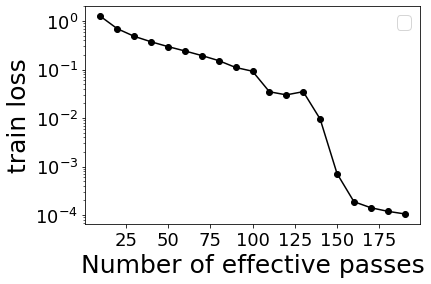

In [ ]:
plot_loss(history)

## SMG with Diminishing Learning Rate Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()

model = LeNet5()
model = model.to(device)
epoch_count = 200

#learning rate is proposed in the paper as 0.1
scheduler = diminishing_learning_rate_scheduler(0.5, 8)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epoch_count, cifar_train_loader, cifar_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 200: avg. loss of last epoch 2.1047423567962658
avg. grad_norm of last epoch 0.8380791472353678
Current train acc: 31.904%, test acc: 32.7%
Epoch 2 / 200: avg. loss of last epoch 1.7503675939941414
avg. grad_norm of last epoch 2.8467464872150243
Current train acc: 43.23%, test acc: 43.07%
Epoch 3 / 200: avg. loss of last epoch 1.51140309387207
avg. grad_norm of last epoch 2.4028364164245164
Current train acc: 42.92%, test acc: 43.05%
Epoch 4 / 200: avg. loss of last epoch 1.4060277851867682
avg. grad_norm of last epoch 3.190936455067192
Current train acc: 50.188%, test acc: 49.06%
Epoch 5 / 200: avg. loss of last epoch 1.2899491244125363
avg. grad_norm of last epoch 2.760125156733212
Current train acc: 53.68%, test acc: 52.05%
Epoch 6 / 200: avg. loss of last epoch 1.2257210710525508
avg. grad_norm of last epoch 3.6059821227653575
Current train acc: 52.286%, test acc: 50.09%
Epoch 7 / 200: avg. loss of last epoch 1.1553387166595455
avg. grad_norm of last epoch 3.4413869562136

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-Cifar10-History/SMG_diminishingLR.json", history)

No handles with labels found to put in legend.


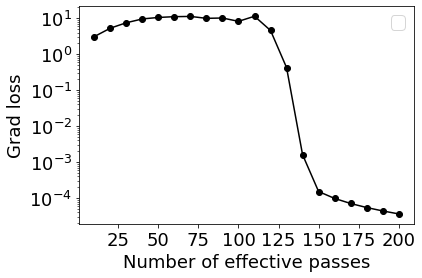

In [ ]:
plot_norm_square_grad(history)

No handles with labels found to put in legend.


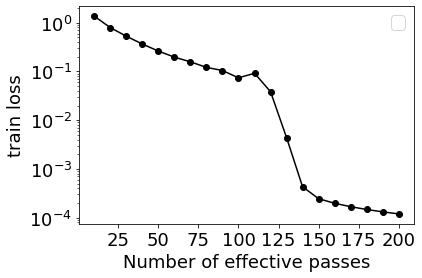

In [ ]:
plot_loss(history)

## SMG with Exponential Learning Rate Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()

model = LeNet5()
model = model.to(device)
epoch_count = 200

#learning rate is proposed in the paper as 0.1
scheduler = exponential_learning_rate_scheduler(0.5, 0.99)

# beta is proposed in paper and epoch_count is inferenced from the graphs
history = SMG_train(model, criterion, epoch_count, cifar_train_loader, cifar_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 200: avg. loss of last epoch 2.034167192916869
avg. grad_norm of last epoch 0.959303976229543
Current train acc: 29.084%, test acc: 28.38%
Epoch 2 / 200: avg. loss of last epoch 1.6353464108657836
avg. grad_norm of last epoch 1.7947900563717023
Current train acc: 43.21%, test acc: 43.5%
Epoch 3 / 200: avg. loss of last epoch 1.4259424222564705
avg. grad_norm of last epoch 1.6701666203384007
Current train acc: 49.122%, test acc: 48.09%
Epoch 4 / 200: avg. loss of last epoch 1.2972395575714113
avg. grad_norm of last epoch 1.9318766376299634
Current train acc: 55.336%, test acc: 52.85%
Epoch 5 / 200: avg. loss of last epoch 1.1879731765556345
avg. grad_norm of last epoch 1.9706002464715702
Current train acc: 59.126%, test acc: 55.72%
Epoch 6 / 200: avg. loss of last epoch 1.1213040849494933
avg. grad_norm of last epoch 2.3838825486911497
Current train acc: 61.56%, test acc: 57.1%
Epoch 7 / 200: avg. loss of last epoch 1.0361533812713621
avg. grad_norm of last epoch 2.24475483773

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-Cifar10-History/SMG_exponentialLR.json", history)

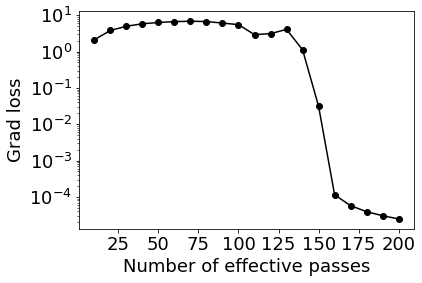

In [ ]:
plot_norm_square_grad(history)

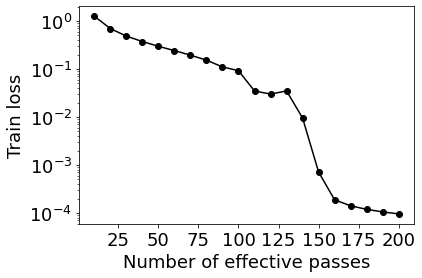

In [ ]:
plot_loss(history)

## SMG with Cosine Learning Rate Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()

model = LeNet5()
model = model.to(device)
epoch_count = 200

#learning rate is proposed in the paper as 0.1
scheduler = cosine_learning_rate_scheduler(0.1, epoch_count)

# beta is proposed in paper and epoch_count is inferred from the graphs
history = SMG_train(model, criterion, epoch_count, cifar_train_loader, cifar_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Epoch 1 / 200: avg. loss of last epoch 2.1732582486724854
avg. grad_norm of last epoch 0.7954390678470844
Current train acc: 24.392%, test acc: 24.21%
Epoch 2 / 200: avg. loss of last epoch 1.8153144768905631
avg. grad_norm of last epoch 2.715851714043966
Current train acc: 36.752%, test acc: 36.52%
Epoch 3 / 200: avg. loss of last epoch 1.5715513942337032
avg. grad_norm of last epoch 2.670188116604791
Current train acc: 43.124%, test acc: 42.91%
Epoch 4 / 200: avg. loss of last epoch 1.4518033911132817
avg. grad_norm of last epoch 2.991101932989537
Current train acc: 49.578%, test acc: 49.53%
Epoch 5 / 200: avg. loss of last epoch 1.3480466707611083
avg. grad_norm of last epoch 2.7803705224382056
Current train acc: 51.316%, test acc: 49.61%
Epoch 6 / 200: avg. loss of last epoch 1.283841608047486
avg. grad_norm of last epoch 3.463055071801188
Current train acc: 52.132%, test acc: 50.27%
Epoch 7 / 200: avg. loss of last epoch 1.2062096528816226
avg. grad_norm of last epoch 3.3309465211

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/SMG-Cifar10-History/SMG_cosineLR.json", history)

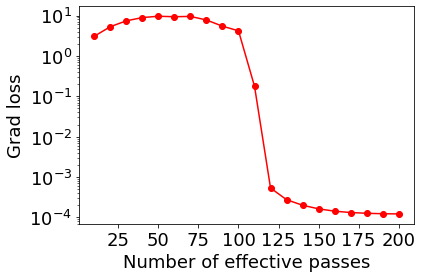

In [ ]:
plot_norm_square_grad(history)

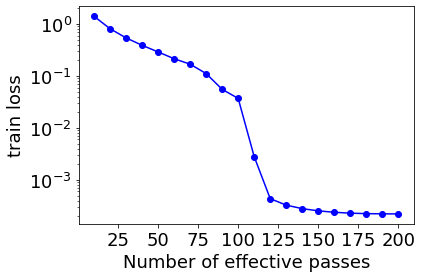

In [ ]:
plot_loss(history)

# 2- Train Other Models and Compare over SMG 
## All optimizers have constant learning scheduler as proposed in the paper

## Train with Adam

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

model = LeNet5()
model = model.to(device)
epochs = 200

# lr is proposed as 0.001 and betas (0.9, 0.999) in paper
scheduler = constant_learning_rate_scheduler(0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

adam_history = train(model, criterion, optimizer, epochs, cifar_train_loader, cifar_test_loader, scheduler)

Epoch 1 / 200: avg. loss of last epoch 1.7271713815307623
Epoch 1 / 200: avg. grad_norm of last epoch 5.954278913241552
Current train acc: 44.71%, test acc: 43.91%
Epoch 2 / 200: avg. loss of last epoch 1.4228515950775145
Epoch 2 / 200: avg. grad_norm of last epoch 10.808499812863205
Current train acc: 52.284%, test acc: 51.91%
Epoch 3 / 200: avg. loss of last epoch 1.2931610500335682
Epoch 3 / 200: avg. grad_norm of last epoch 10.853980315773388
Current train acc: 55.074%, test acc: 54.34%
Epoch 4 / 200: avg. loss of last epoch 1.2120790966415413
Epoch 4 / 200: avg. grad_norm of last epoch 12.118126336876946
Current train acc: 58.736%, test acc: 57.51%
Epoch 5 / 200: avg. loss of last epoch 1.1493019503402713
Epoch 5 / 200: avg. grad_norm of last epoch 13.633605954912033
Current train acc: 61.01%, test acc: 59.07%
Epoch 6 / 200: avg. loss of last epoch 1.0971529851531978
Epoch 6 / 200: avg. grad_norm of last epoch 12.872231297535919
Current train acc: 62.502%, test acc: 60.62%
Epoch 7

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/Cifar10-Other-Optimizers/ADAM_constantLR.json", adam_history)

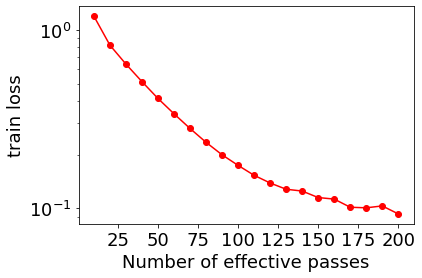

In [ ]:
plot_loss(adam_history)

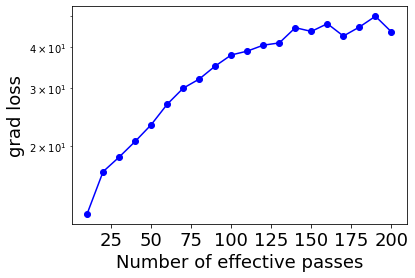

In [ ]:
plot_norm_square_grad(adam_history)

## Train with SGD

In [ ]:
criterion = nn.CrossEntropyLoss()

model = LeNet5()
model = model.to(device)
epochs = 200

# lr is proposed as 0.1
scheduler = constant_learning_rate_scheduler(0.04)
optimizer = optim.SGD(model.parameters(), lr=0.04)

sgd_history = train(model, criterion, optimizer, epochs, cifar_train_loader, cifar_test_loader, scheduler)

Epoch 1 / 200: avg. loss of last epoch 2.2378236167144774
Epoch 1 / 200: avg. grad_norm of last epoch 0.37089357219247476
Current train acc: 27.238%, test acc: 27.64%
Epoch 2 / 200: avg. loss of last epoch 1.8753540950775147
Epoch 2 / 200: avg. grad_norm of last epoch 4.200004186567753
Current train acc: 36.158%, test acc: 36.25%
Epoch 3 / 200: avg. loss of last epoch 1.6699842551422115
Epoch 3 / 200: avg. grad_norm of last epoch 5.432024558473579
Current train acc: 41.396%, test acc: 41.23%
Epoch 4 / 200: avg. loss of last epoch 1.5353530115509033
Epoch 4 / 200: avg. grad_norm of last epoch 5.923803534147748
Current train acc: 46.034%, test acc: 45.92%
Epoch 5 / 200: avg. loss of last epoch 1.4466421866226187
Epoch 5 / 200: avg. grad_norm of last epoch 6.1562759849622735
Current train acc: 49.3%, test acc: 48.31%
Epoch 6 / 200: avg. loss of last epoch 1.3821009347534174
Epoch 6 / 200: avg. grad_norm of last epoch 6.792377337846977
Current train acc: 51.712%, test acc: 50.57%
Epoch 7 /

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/Cifar10-Other-Optimizers/SGD_constantLR.json", sgd_history)

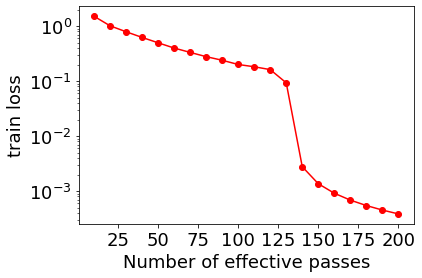

In [ ]:
plot_loss(sgd_history)

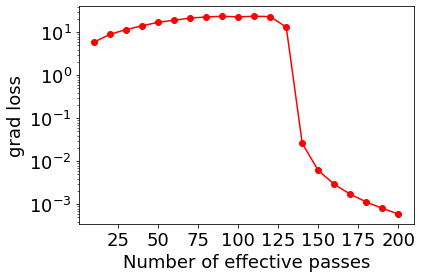

In [ ]:
plot_norm_square_grad(sgd_history)

## Train with SGD-M

In [ ]:
criterion = nn.CrossEntropyLoss()

model = LeNet5()
model = model.to(device)
epochs = 200

# lr is proposed as 0.1 and momentum is used as 0.5
scheduler = constant_learning_rate_scheduler(0.02)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.5)

sgdm_history = train(model, criterion, optimizer, epochs, cifar_train_loader, cifar_test_loader, scheduler)

Epoch 1 / 200: avg. loss of last epoch 2.3000845780944825
Epoch 1 / 200: avg. grad_norm of last epoch 0.009431621816997703
Current train acc: 11.634%, test acc: 11.71%
Epoch 2 / 200: avg. loss of last epoch 2.176997838668824
Epoch 2 / 200: avg. grad_norm of last epoch 0.40240209429189844
Current train acc: 27.854%, test acc: 28.16%
Epoch 3 / 200: avg. loss of last epoch 1.9061486132812504
Epoch 3 / 200: avg. grad_norm of last epoch 2.599280669289947
Current train acc: 31.36%, test acc: 31.42%
Epoch 4 / 200: avg. loss of last epoch 1.75446549823761
Epoch 4 / 200: avg. grad_norm of last epoch 5.4281933447333675
Current train acc: 36.548%, test acc: 36.44%
Epoch 5 / 200: avg. loss of last epoch 1.660961975135804
Epoch 5 / 200: avg. grad_norm of last epoch 5.854554730407857
Current train acc: 39.864%, test acc: 40.21%
Epoch 6 / 200: avg. loss of last epoch 1.5892853513336191
Epoch 6 / 200: avg. grad_norm of last epoch 5.812232638631302
Current train acc: 43.318%, test acc: 43.01%
Epoch 7 /

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/Cifar10-Other-Optimizers/SGDM_constantLR.json", sgdm_history)

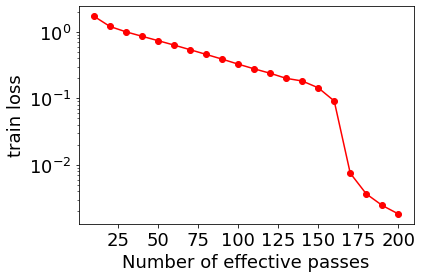

In [ ]:
plot_loss(sgdm_history)

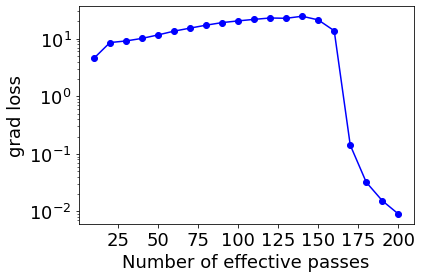

In [ ]:
plot_norm_square_grad(sgdm_history)

## Train with SSMG

In [ ]:
criterion = nn.CrossEntropyLoss()

model = LeNet5()
model = model.to(device)
epoch_count = 200


scheduler = constant_learning_rate_scheduler(0.1)

#SSMG is single shuffle variant of the SMG (with different optimizer step.) 
#Thus, reload the batch by shuffling it once and disable shuffling in every epoch
cifar_train_loader, cifar_test_loader = cifar10_loader(128, True)

# beta is proposed in paper and epoch_count is inferenced from the graphs
ssmg_history = SSMG_train(model, criterion, epoch_count, cifar_train_loader, cifar_test_loader, 
                    scheduler, beta=0.5, verbose=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1 / 200: avg. loss of last epoch 2.0171119832611075
avg. grad_norm of last epoch 1.8129401437617216
Current train acc: 36.246%, test acc: 36.01%
Epoch 2 / 200: avg. loss of last epoch 1.567147418174744
avg. grad_norm of last epoch 5.099025824447622
Current train acc: 48.892%, test acc: 48.23%
Epoch 3 / 200: avg. loss of last epoch 1.3657088848114005
avg. grad_norm of last epoch 5.699980502635777
Current train acc: 54.268%, test acc: 53.39%
Epoch 4 / 200: avg. loss of last epoch 1.2486752800750733
avg. grad_norm of last epoch 5.925714848917217
Current train acc: 58.91%, test acc: 57.32%
Epoch 5 / 200: avg. loss of last epoch 1.1572884632492062
avg. grad_norm of last epoch 5.920921792731603
Current train acc: 61.822%, test acc: 59.34%
Epoch 6 / 200: avg. loss of last epoch 1.083442334632874
avg. grad_norm of last epoch 6.129812365087928
Current train acc: 63.878%, test acc: 60.44%
Epoch 7 / 200: avg. loss o

In [ ]:
#Save the history
save_history_json("/content/gdrive/MyDrive/SMGExperiments/Cifar10-Other-Optimizers/SSMG_constantLR.json", ssmg_history)

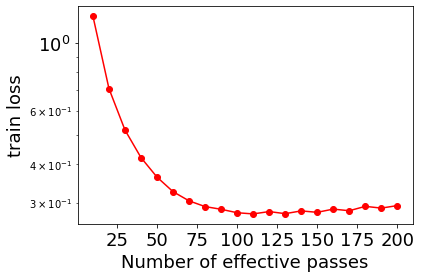

In [ ]:
plot_loss(ssmg_history)

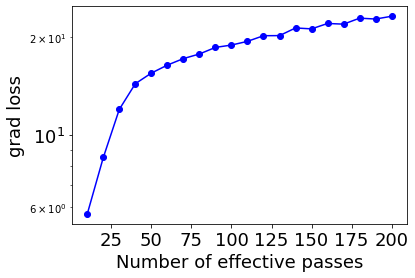

In [ ]:
plot_norm_square_grad(ssmg_history)